In [ ]:
# Deep Learning for Data Science
# University of West Florida
#
# Project: Adam Optimizer
#
# Evaluate the performance of the Adam optimizer
# on the IMDB dataset using a simple neural network.
#
# =============================================================================

# Import necessary libraries
import numpy as np
from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing.text import Tokenizer

# Load the IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Decode the reviews back to text (for understanding)
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

decoded_reviews = [decode_review(review) for review in x_train[:5]]
for i, review in enumerate(decoded_reviews):
    print(f"Review {i + 1}: {review}")


Review 1: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don

In [ ]:
# Initialize the tokenizer with the top 10,000 words
tokenizer = Tokenizer(num_words=10000)
x_train_texts = [decode_review(review) for review in x_train]
x_test_texts = [decode_review(review) for review in x_test]

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(x_train_texts)

# Convert the texts to BoW vectors
x_train_bow = tokenizer.texts_to_matrix(x_train_texts, mode='binary')
x_test_bow = tokenizer.texts_to_matrix(x_test_texts, mode='binary')

# Check the shape of the BoW feature vectors
print(f"x_train_bow shape: {x_train_bow.shape}")
print(f"x_test_bow shape: {x_test_bow.shape}")


x_train_bow shape: (25000, 10000)
x_test_bow shape: (25000, 10000)


In [ ]:
# Calculate sparsity
train_sparsity = 1.0 - np.count_nonzero(x_train_bow) / x_train_bow.size
test_sparsity = 1.0 - np.count_nonzero(x_test_bow) / x_test_bow.size

print(f"Training data sparsity: {train_sparsity:.4f}")
print(f"Test data sparsity: {test_sparsity:.4f}")


Training data sparsity: 0.9870
Test data sparsity: 0.9873


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad

def create_bow_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(10000,)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:

%%time
# Compile and train the model with several optimizers

def train_model(optimizer, x_train, y_train, x_val, y_val):
  model = create_bow_model()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=180, batch_size=512, validation_split=0.2, verbose=2)
  return model, history

adam_lr_model, adam_lr_history = train_model(Adam(), x_train_bow, y_train, x_test_bow, y_test)
rmsprop_lr_model, rmsprop_lr_history = train_model(RMSprop(), x_train_bow, y_train, x_test_bow, y_test)
adagrad_lr_model, adagrad_lr_history = train_model(Adagrad(learning_rate=0.01), x_train_bow, y_train, x_test_bow, y_test)
sgd_lr_model, sgd_lr_history = train_model(SGD(learning_rate=0.01, nesterov=True), x_train_bow, y_train, x_test_bow, y_test)


Epoch 1/180
40/40 - 4s - loss: 0.4212 - accuracy: 0.8040 - val_loss: 0.3316 - val_accuracy: 0.8684
Epoch 2/180
40/40 - 2s - loss: 0.2013 - accuracy: 0.9216 - val_loss: 0.2778 - val_accuracy: 0.8960
Epoch 3/180
40/40 - 2s - loss: 0.1155 - accuracy: 0.9599 - val_loss: 0.3185 - val_accuracy: 0.8832
Epoch 4/180
40/40 - 3s - loss: 0.0604 - accuracy: 0.9822 - val_loss: 0.3920 - val_accuracy: 0.8820
Epoch 5/180
40/40 - 2s - loss: 0.0266 - accuracy: 0.9933 - val_loss: 0.4638 - val_accuracy: 0.8806
Epoch 6/180
40/40 - 2s - loss: 0.0114 - accuracy: 0.9977 - val_loss: 0.5621 - val_accuracy: 0.8810
Epoch 7/180
40/40 - 2s - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.5933 - val_accuracy: 0.8810
Epoch 8/180
40/40 - 2s - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.6311 - val_accuracy: 0.8794
Epoch 9/180
40/40 - 3s - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.6517 - val_accuracy: 0.8836
Epoch 10/180
40/40 - 2s - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.6618 - val_accuracy: 0.8822
Epoch 11/

In [ ]:
# Evaluate the several models on the test set
test_loss, test_accuracy = adam_lr_model.evaluate(x_test_bow, y_test, verbose=2)
print(f"Adam test accuracy: {test_accuracy:.4f}")

test_loss, test_accuracy = rmsprop_lr_model.evaluate(x_test_bow, y_test, verbose=2)
print(f"RMSprop test accuracy: {test_accuracy:.4f}")

test_loss, test_accuracy = adagrad_lr_model.evaluate(x_test_bow, y_test, verbose=2)
print(f"Adagrad test accuracy: {test_accuracy:.4f}")

test_loss, test_accuracy = sgd_lr_model.evaluate(x_test_bow, y_test, verbose=2)
print(f"SGD test accuracy: {test_accuracy:.4f}")


782/782 - 3s - loss: 1.2888 - accuracy: 0.8694
Adam test accuracy: 0.8694
782/782 - 4s - loss: 13.2169 - accuracy: 0.7912
RMSprop test accuracy: 0.7912
782/782 - 4s - loss: 0.4955 - accuracy: 0.8786
Adagrad test accuracy: 0.8786
782/782 - 4s - loss: 0.3114 - accuracy: 0.8811
SGD test accuracy: 0.8811


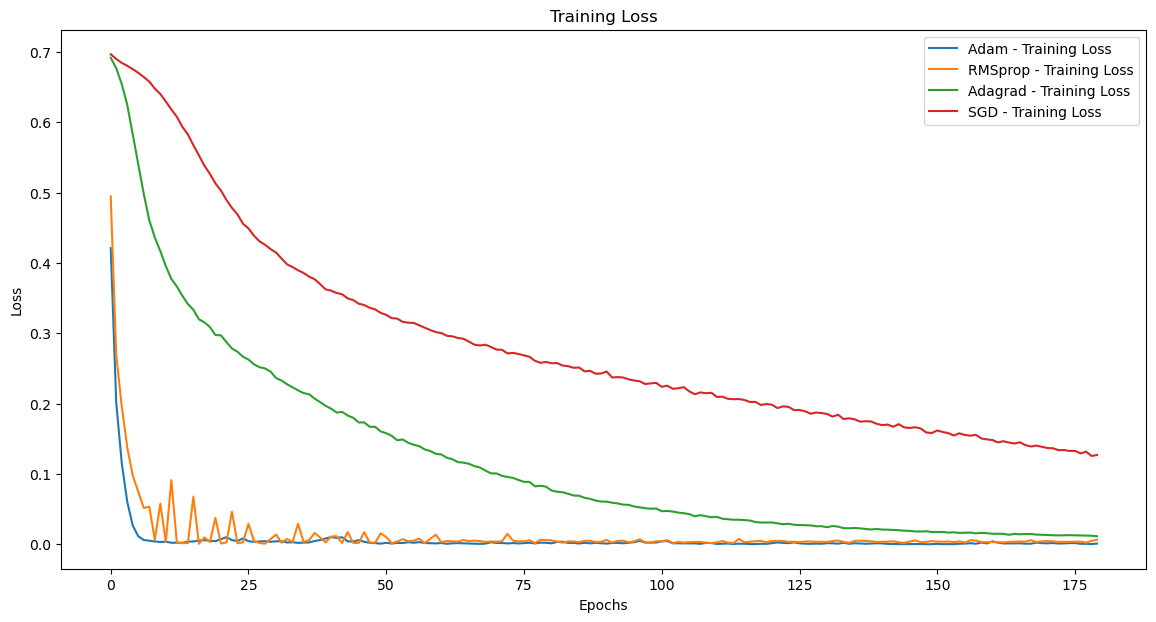

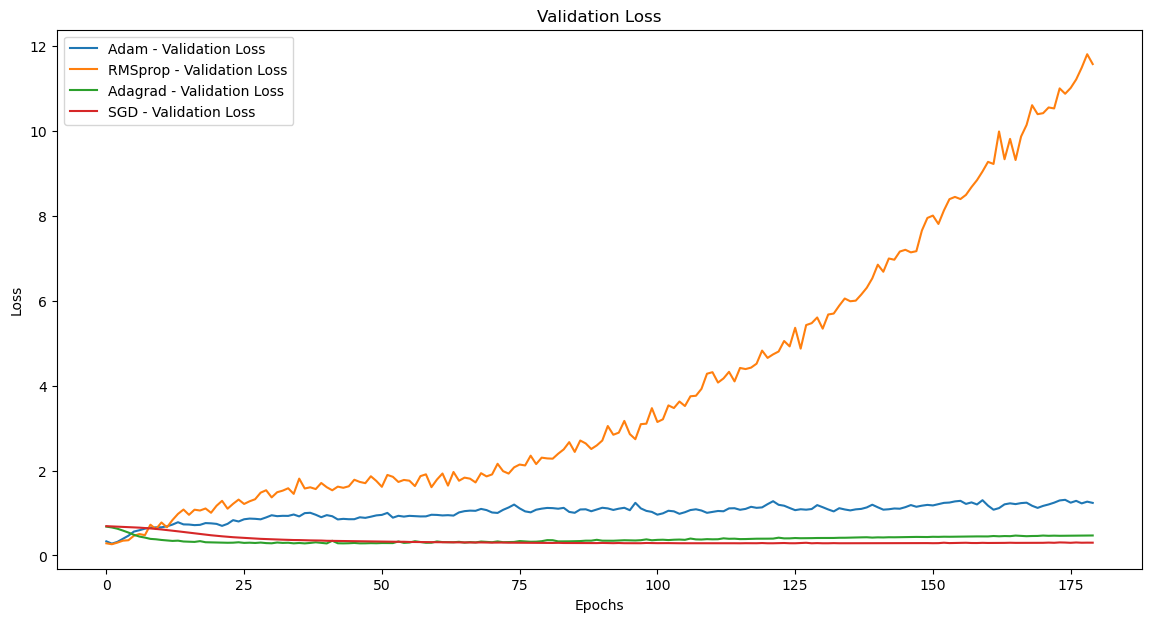

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss
def plot_loss(histories, optimizer_names, loss='loss'):

    if loss == 'val_loss':
        title = 'Validation Loss'
    else:
        title = 'Training Loss'

    plt.figure(figsize=(14, 7))

    for history, name in zip(histories, optimizer_names):
        plt.plot(history.history[loss], label=f'{name} - {title}')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the results

plot_loss([adam_lr_history, rmsprop_lr_history, adagrad_lr_history, sgd_lr_history], ['Adam', 'RMSprop', 'Adagrad', 'SGD'], 'loss')
plot_loss([adam_lr_history, rmsprop_lr_history, adagrad_lr_history, sgd_lr_history], ['Adam', 'RMSprop', 'Adagrad', 'SGD'], 'val_loss')